In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.functional import f1
from string import punctuation
from nltk import TweetTokenizer
import pandas as pd
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [11]:
positive_df = pd.read_csv("drive/MyDrive/Colab Notebooks/positive.csv", sep=";")

In [12]:
positive_df.head()

,tid,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [13]:
negative_df = pd.read_csv("drive/MyDrive/Colab Notebooks/negative.csv", sep=";")

In [14]:
negative_df.head()

,tid,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [15]:
df = pd.concat([positive_df, negative_df], ignore_index=True)

In [16]:
df["ttype"] = df["ttype"].replace([-1], 0)

In [17]:
def clean_tokens(tokens):
    clean_tokens = []
    for token in tokens:
        if token not in punctuation:
            clean_tokens.append(token)
    return clean_tokens

In [23]:
tw = TweetTokenizer()

In [21]:
def clean_tokenize(text):
    return clean_tokens(tw.tokenize(text))

In [24]:
df["ttext_tokenized"] = df["ttext"].apply(clean_tokenize)

In [26]:
df.head()

,tid,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfoll,tfrien,listcount,ttext_nopunct,ttext_tokenized
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,firsttimee хоть я и школота но поверь у нас то...,"[@first_timee, хоть, я, и, школота, но, поверь..."
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,а все-таки он немного похож на него о мой маль...,"[Да, все-таки, он, немного, похож, на, него, Н..."
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,atiaheh у ты идиотка я испугалась за тебя,"[RT, @KatiaCheh, Ну, ты, идиотка, я, испугалас..."
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,digger то то в углу сидит и погибает от голод...,"[RT, @digger2912, Кто, то, в, углу, сидит, и, ..."
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,irinadyshkant от что значит страшилка о блинпо...,"[@irina_dyshkant, Вот, что, значит, страшилка,..."


In [27]:
train_data, val_data = train_test_split(df, test_size=0.2)

In [28]:
vocab = Counter()
for tokens in df['ttext_tokenized']:
    vocab.update(list([token.lower() for token in tokens]))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 302593


In [29]:
filtered_vocab = set()

for token in vocab:
    if vocab[token] > 10:
        filtered_vocab.add(token)

In [30]:
len(filtered_vocab)

17767

In [89]:
token2id = {'PAD':0}

for token in filtered_vocab:
    token2id[token] = len(token2id)

In [91]:
id2token = {i:token for token, i in token2id.items()}

In [33]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [205]:
class TweetDataset(Dataset):

    def __init__(self, dataset, symbol2id, DEVICE):
        self.dataset = dataset['ttext_tokenized'].values
        self.token2id = token2id
        self.length = dataset.shape[0]
        self.target = dataset['ttype'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = list(self.dataset[index])
        ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [206]:
train_dataset = TweetDataset(train_data, token2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [207]:
batch = next(iter(train_iterator))

In [208]:
[id2token[int(i)] for i in batch[0][0]]

['нас',
 'не',
 'столько',
 'тепло',
 'а',
 'больше',
 'мерзко',
 'мне',
 'кажется',
 'соответствует',
 'состоянию',
 'душ',
 'людей',
 'здесь',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [209]:
batch[1]

tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [210]:
val_dataset = TweetDataset(val_data, token2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [211]:
test_batch = next(iter(val_iterator))
test_batch[0].shape

torch.Size([1024, 27])

In [212]:
test_batch[1].shape

torch.Size([1024, 1])

In [213]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.bigrams(embedded)
        feature_map_trigrams = self.trigrams(embedded)
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat_bigrams = self.bigrams2(concat)
        pooling = self.pooling(concat_bigrams)
        pooling = pooling.max(2)[0]

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [214]:
batch, y = next(iter(train_iterator))
batch, y = batch.to(device='cpu'), y.to(device='cpu')
print(batch)

tensor([[10442, 15714, 13853,  ...,     0,     0,     0],
        [11135, 17440,  5488,  ...,     0,     0,     0],
        [ 5488,  4470, 15684,  ...,     0,     0,     0],
        ...,
        [13322,  2972,  1081,  ...,     0,     0,     0],
        [ 1528, 13060,   262,  ...,     0,     0,     0],
        [10851,  5488,   680,  ...,     0,     0,     0]])


In [215]:
loss = nn.BCELoss()

In [216]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() 
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [217]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [218]:
model = CNN(len(token2id), 64)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [219]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [220]:
def train_and_evaluate(model, t_iterator, v_iterator, optimizer, criterion, epochs=20):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, t_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, t_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, v_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
    return losses, losses_eval, f1s, f1s_eval

In [221]:
losses, losses_eval, f1s, f1s_eval = train_and_evaluate(model, train_iterator, val_iterator, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.5958426296710968
Train loss: 0.5426107260628023
Train loss: 0.5170400050970224
Train loss: 0.5012678323889808
Train loss: 0.49077561292155036

Evaluating on train...
Val loss: 0.450553958030308, Val f1: 0.8013055324554443
Val loss: 0.4410050196060236, Val f1: 0.7909575700759888
Val loss: 0.4390820829341045, Val f1: 0.7865371108055115
Val loss: 0.43675150502499915, Val f1: 0.7858590483665466
Val loss: 0.4365836638828804, Val f1: 0.7845079302787781

Evaluating on test...
Val loss: 0.4963986650109291, Val f1: 0.8618367314338684
Val loss: 0.46328409103786244, Val f1: 0.8185535073280334
Val loss: 0.45755846454547, Val f1: 0.8020468950271606
Val loss: 0.451433994940349, Val f1: 0.7950359582901001
Val loss: 0.4484576176513325, Val f1: 0.7902715802192688

starting Epoch 1
Training...
Train loss: 0.44221092672909007
Train loss: 0.43418366753536725
Train loss: 0.42960279148358566
Train loss: 0.4281327597957721
Train loss: 0.42554233266019276

Evaluatin

In [172]:
import matplotlib.pyplot as plt

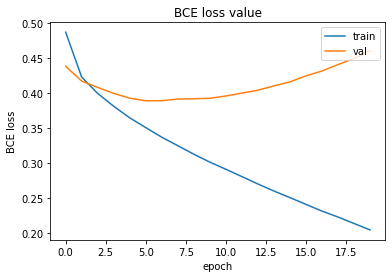

In [222]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

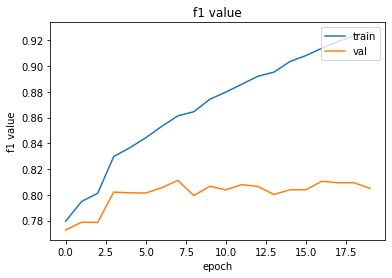

In [223]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [50]:
import numpy as np

In [54]:
from gensim.models import FastText

In [66]:
fasttext_embedder = FastText()

In [67]:
fasttext_embedder.build_vocab(list(df.ttext_tokenized))
fasttext_embedder.train(list(df.ttext_tokenized), total_examples=len(df.ttext_tokenized), epochs=10)

In [69]:
fasttext_embedder.wv["мама"].shape

(100,)

In [82]:
fasttext_embedder.wv["папа"]

array([ 1.104259  ,  2.6314988 , -1.2894822 , -1.3851539 ,  0.18350072,
        0.05627035, -1.7010925 ,  1.2807451 ,  1.0405988 , -0.681419  ,
        0.43647575, -0.29110014,  0.773079  ,  0.25099728, -0.5357984 ,
        2.3608332 ,  1.206548  ,  0.7134988 , -2.1065798 , -1.3348185 ,
       -0.10672606,  0.07607281,  0.07393667,  1.8630462 ,  2.7078922 ,
        0.08921336, -0.13595122, -1.4600787 ,  0.7293571 ,  1.1008493 ,
       -2.1741583 ,  0.6219857 ,  1.882422  , -1.142107  ,  1.124455  ,
       -2.3659337 , -1.7501439 , -0.9901385 , -0.579732  ,  0.2776633 ,
        0.21764556, -0.7905479 ,  1.8216923 ,  1.3590729 ,  0.3231027 ,
       -0.81875134,  0.6311111 ,  0.05106393,  0.27669457, -0.10012718,
       -1.0740523 ,  0.12970787,  0.6361233 ,  1.2698029 ,  1.0528421 ,
        2.5145237 , -2.6372223 , -0.40141475,  0.4966553 , -2.0296266 ,
        0.22155653,  1.3401242 ,  0.5227219 ,  0.05153894, -0.5809259 ,
       -2.970009  ,  0.5833199 ,  0.8618181 , -0.42640707, -0.14

In [92]:
fasttext_embeddings = np.zeros((len(token2id), 100))
for token in token2id.keys():
    try:
        fasttext_embeddings[token2id[token]] = fasttext_embedder.wv[token]
    except:
        pass

In [94]:
fasttext_embeddings[token2id["мама"]] == fasttext_embedder.wv["мама"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [95]:
fasttext_embeddings.shape

(17768, 100)

Как можно улучшить модель? Мы видим, что она явно переобучается, соответственно можно добавить классический способ борьбы с этим -- dropout. Также добавим ReLU для той же цели (погасить некоторые нейроны).


In [224]:
class CNN_improved(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.out = nn.Sigmoid()

        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
    
    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        concat_bigrams = self.dropout(self.relu(self.bigrams2(concat)))
        pooling = self.pooling(concat_bigrams)
        pooling = pooling.max(2)[0]

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

Увеличим и размерность эмбеддинга.

In [226]:
model = CNN_improved(len(token2id), 300)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [227]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [228]:
imp_losses, imp_losses_eval, imp_f1s, imp_f1s_eval = train_and_evaluate(model, train_iterator, val_iterator, optimizer, criterion)


starting Epoch 0
Training...
Train loss: 0.6113580956178553
Train loss: 0.5462299498958864
Train loss: 0.5153798546928626
Train loss: 0.49710168598367155
Train loss: 0.48353994098202935

Evaluating on train...
Val loss: 0.4370041112689411, Val f1: 0.8052672743797302
Val loss: 0.43014194956724194, Val f1: 0.7955449223518372
Val loss: 0.4267832777247979, Val f1: 0.7935517430305481
Val loss: 0.4254841058374309, Val f1: 0.7907326221466064
Val loss: 0.4243343369714145, Val f1: 0.7894246578216553

Evaluating on test...
Val loss: 0.48185599222779274, Val f1: 0.8679196834564209
Val loss: 0.45152151584625244, Val f1: 0.820949912071228
Val loss: 0.44444400874468, Val f1: 0.8032055497169495
Val loss: 0.4388720342091152, Val f1: 0.797653079032898
Val loss: 0.43583243069323624, Val f1: 0.7919972538948059

starting Epoch 1
Training...
Train loss: 0.4299748364616843
Train loss: 0.4207443370335344
Train loss: 0.4177630847463241
Train loss: 0.41414275551013807
Train loss: 0.4120038115772708

Evaluatin

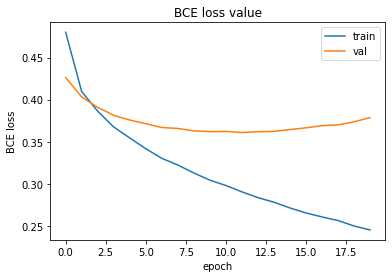

In [229]:
plt.plot(imp_losses)
plt.plot(imp_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

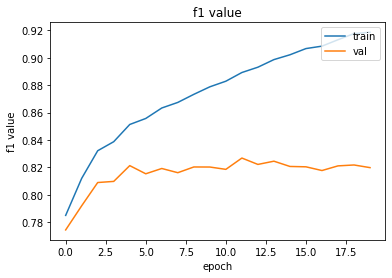

In [230]:
plt.plot(imp_f1s)
plt.plot(imp_f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

В итоге модель немного улучшилась. Мое подозрение в том, что размерность эмбеддинга не так сильно повлияла, как дропаут и релу.

In [245]:
def tfpn(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2token[int(token)] for token in text if token !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [246]:
fp, fn, tp, tn = tfpn(model, val_iterator)

Сonfusion matrix:

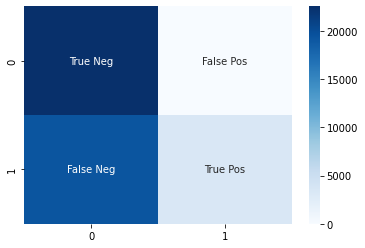

In [265]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(tr, pr)
labels = ["TN", "FP", "False Neg", "True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues')

# 2

In [100]:
char_vocab = Counter()
for text in df['ttext']:
    char_vocab.update(list(text))
print('всего уникальных символов:', len(char_vocab))

всего уникальных символов: 456


In [101]:
filtered_char_vocab = set()

for char in char_vocab:
    if char_vocab[char] > 20:
        filtered_char_vocab.add(char)

In [102]:
symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

In [103]:
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

In [156]:
class TweetMixedDataset(Dataset):
    
    def __init__(self, dataset, token2id, symbol2id, DEVICE):
        self.dataset = dataset['ttext_tokenized'].values, dataset['ttext'].values
        self.token2id = token2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['ttype'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[0][index]
        token_ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])
        chars = list(self.dataset[1][index])
        char_ids = torch.LongTensor([self.symbol2id[char] for char in chars if char in self.symbol2id])
        y = [self.target[index]]
        return token_ids, char_ids, y

    def collate_fn(self, batch):
        token_ids, char_ids, y = list(zip(*batch))
        padded_token_ids = pad_sequence(token_ids, batch_first=True).to(self.device)
        padded_symbol_ids = pad_sequence(char_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_token_ids, padded_symbol_ids, y

In [157]:
train_dataset = TweetMixedDataset(train_data, token2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [158]:
val_dataset = TweetMixedDataset(val_data, token2id, symbol2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [159]:
class MixedCNN(nn.Module):
    
    def __init__(self,
                 token_vocab_size,
                 symbol_vocab_size,
                 char_embedding_dim):
        super().__init__()
        
        self.token_embedding = nn.Embedding.from_pretrained(torch.Tensor(fasttext_embeddings))
        self.token_hidden = nn.Linear(100, 100)
        
        self.char_embedding = nn.Embedding(symbol_vocab_size, char_embedding_dim)
        self.char_bigrams = nn.Conv1d(in_channels=char_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.char_trigrams = nn.Conv1d(in_channels=char_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        
        self.char_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.hidden_out = nn.Linear(280, 1)
        self.out = nn.Sigmoid()
    
    def forward(self, tokens, chars):
        tokens_embedded = self.token_embedding(tokens)
        tokens_embedded = tokens_embedded.transpose(1,2).max(2)[0]
        token_hidden = self.token_hidden(tokens_embedded)
        
        char_embedded = self.char_embedding(chars)
        char_embedded = char_embedded.transpose(1,2)
        feature_map_bigrams = self.char_pooling(self.relu(self.char_bigrams(char_embedded)))
        feature_map_trigrams = self.char_pooling(self.relu(self.char_trigrams(char_embedded)))
        pooling_bigrams = feature_map_bigrams.max(2)[0]
        pooling_trigrams = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling_bigrams, pooling_trigrams), 1)
        
        concat_out = torch.cat((token_hidden, concat), 1)
        logits = self.hidden_out(concat_out)
        logits = self.out(logits)
        return logits

In [160]:
batch = next(iter(train_iterator))

Пример того, как устроен батч:

In [161]:
batch[0]

tensor([[ 8371,  4727, 11020,  ...,     0,     0,     0],
        [12006,   863,  7297,  ...,     0,     0,     0],
        [12137, 12295, 13038,  ...,     0,     0,     0],
        ...,
        [ 2296, 13597,  8223,  ...,     0,     0,     0],
        [ 5306, 17566,  3226,  ...,     0,     0,     0],
        [12936, 10661,  7604,  ...,     0,     0,     0]], device='cuda:0')

In [162]:
batch[1]

tensor([[174,  41,  22,  ..., 148,  69,  72],
        [178, 107,  22,  ...,   0,   0,   0],
        [164,  41, 112,  ...,   0,   0,   0],
        ...,
        [153, 139, 190,  ...,   0,   0,   0],
        [174, 155, 130,  ...,   0,   0,   0],
        [ 73,  69, 123,  ...,   0,   0,   0]], device='cuda:0')

In [163]:
batch[2]

tensor([[0.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [1.]], device='cuda:0')

In [164]:
model = MixedCNN(len(id2token), len(id2symbol), 10)
model = model.to(DEVICE)
output = model(batch[0], batch[1])
print(output)

tensor([[0.1353],
        [0.1423],
        [0.2797],
        ...,
        [0.3487],
        [0.2265],
        [0.3670]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [165]:
output.mean()

tensor(0.2203, device='cuda:0', grad_fn=<MeanBackward0>)

In [166]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [167]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (texts, chars, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts, chars)
        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i+1)}')      
    return  epoch_loss / len(iterator)

In [168]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, chars, ys) in enumerate(iterator):   
            preds = model(texts, chars)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [169]:
def train_and_evaluate(model, t_iterator, v_iterator, optimizer, criterion, epochs=20):
    losses = []
    losses_eval = []
    f1s = []
    f1s_eval = []

    for i in range(epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, t_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, t_iterator, criterion)
        f1s.append(f1_on_train)
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, v_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test)
    return losses, losses_eval, f1s, f1s_eval

In [170]:
mix_losses, mix_losses_eval, mix_f1s, mix_f1s_eval = train_and_evaluate(model, train_iterator, val_iterator, optimizer, criterion, 10)


starting Epoch 0
Training...
Train loss: 0.7030261857169015
Train loss: 0.6568131574562618
Train loss: 0.6145732127484821
Train loss: 0.5674910113215447
Train loss: 0.5161453262397221

Evaluating on train...
Val loss: 0.24831425717898778, Val f1: 0.9582005143165588
Val loss: 0.24765258367572512, Val f1: 0.958070695400238
Val loss: 0.24818150315965926, Val f1: 0.9576213359832764
Val loss: 0.24841785388333457, Val f1: 0.9576214551925659
Val loss: 0.2484651460817882, Val f1: 0.9575864672660828

Evaluating on test...
Val loss: 0.25029758115609485, Val f1: 0.9545497894287109
Val loss: 0.24828044656250212, Val f1: 0.9566069841384888
Val loss: 0.246888878720778, Val f1: 0.9574328064918518
Val loss: 0.24758992965022722, Val f1: 0.9573214650154114
Val loss: 0.24758165246910518, Val f1: 0.9573948383331299

starting Epoch 1
Training...
Train loss: 0.20714467678751264
Train loss: 0.17649110140545027
Train loss: 0.1553509676740283
Train loss: 0.13952314667403698
Train loss: 0.1270729524748666

Eva

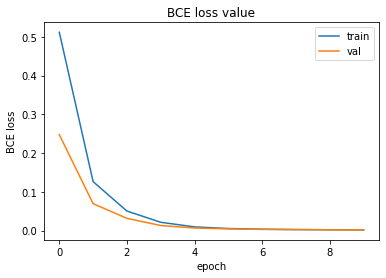

In [173]:
plt.plot(mix_losses)
plt.plot(mix_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

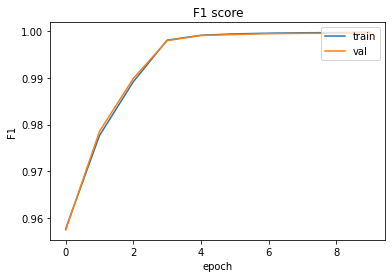

In [174]:
plt.plot(mix_f1s)
plt.plot(mix_f1s_eval)
plt.title('F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Ухудшим модель, поскольку слишком уж хорошая она получается и оптимизировать ее бессмысленно.

In [175]:
import re

In [176]:
def no_punct(text):
    return re.sub("[^a-z а-яё\-]+", "", text)

In [177]:
df["ttext_nopunct"] = df["ttext"].apply(no_punct)

In [178]:
df["ttext_nopunct_tokenized"] = df["ttext_nopunct"].apply(clean_tokenize)

In [92]:
df["ttext_nopunct_tokenized"]

0         [firsttimee, хоть, я, и, школота, но, поверь, ...
1         [а, все-таки, он, немного, похож, на, него, о,...
2         [atiaheh, у, ты, идиотка, я, испугалась, за, т...
3         [digger, то, то, в, углу, сидит, и, погибает, ...
4         [irinadyshkant, от, что, значит, страшилка, о,...
                                ...                        
226829    [о, не, каждый, хочет, что, то, исправлять, ht...
226830    [скучаю, так, только, taaannyaaa, вправляет, м...
226831    [от, и, в, школу, в, говно, это, идти, уже, надо]
226832          [hem, isaeroud, ауриэль, не, грусти, обнял]
226833    [акси, везет, меня, на, работу, аздумываю, при...
Name: ttext_nopunct_tokenized, Length: 226834, dtype: object

In [94]:
df = df.drop(["ttext_nopucnt_tokenized", "ttext_nopucnt"], axis=1)

In [179]:
class TweetNoPunctMixedDataset(Dataset):
    
    def __init__(self, dataset, token2id, symbol2id, DEVICE):
        self.dataset = dataset['ttext_nopunct_tokenized'].values, dataset['ttext_nopunct'].values
        self.token2id = token2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['ttype'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[0][index]
        token_ids = torch.LongTensor([self.token2id[token] for token in tokens if token in self.token2id])
        chars = list(self.dataset[1][index])
        char_ids = torch.LongTensor([self.symbol2id[char] for char in chars if char in self.symbol2id])
        y = [self.target[index]]
        return token_ids, char_ids, y

    def collate_fn(self, batch):
        token_ids, char_ids, y = list(zip(*batch))
        padded_token_ids = pad_sequence(token_ids, batch_first=True).to(self.device)
        padded_symbol_ids = pad_sequence(char_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_token_ids, padded_symbol_ids, y

In [180]:
train_data, val_data = train_test_split(df, test_size=0.2)

In [181]:
train_dataset = TweetNoPunctMixedDataset(train_data, token2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn=train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [182]:
val_dataset = TweetNoPunctMixedDataset(val_data, token2id, symbol2id, DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn=val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [183]:
model = MixedCNN(len(id2token), len(id2symbol), 10)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [184]:
mix_np_losses, mix_np_losses_eval, mix_np_f1s, mix_np_f1s_eval = train_and_evaluate(model, train_iterator, val_iterator, optimizer, criterion, 10)


starting Epoch 0
Training...
Train loss: 0.6983140911374773
Train loss: 0.6842086664267949
Train loss: 0.6756873312450591
Train loss: 0.66956019955022
Train loss: 0.6651484080723353

Evaluating on train...
Val loss: 0.6432480454444885, Val f1: 0.6269960403442383
Val loss: 0.6437503286770412, Val f1: 0.6273746490478516
Val loss: 0.6436986804008484, Val f1: 0.6274717450141907
Val loss: 0.6436664700508118, Val f1: 0.6269793510437012
Val loss: 0.6435890371458871, Val f1: 0.6265784502029419

Evaluating on test...
Val loss: 0.6493217481507195, Val f1: 0.6128045916557312
Val loss: 0.646066771613227, Val f1: 0.6174113154411316
Val loss: 0.6451739823376691, Val f1: 0.6196780800819397
Val loss: 0.6432402713431252, Val f1: 0.6223928928375244
Val loss: 0.6426614244778951, Val f1: 0.6241124272346497

starting Epoch 1
Training...
Train loss: 0.6450943010193961
Train loss: 0.6423449311937605
Train loss: 0.6406671086947123
Train loss: 0.6389603521142687
Train loss: 0.6377077542032514

Evaluating on t

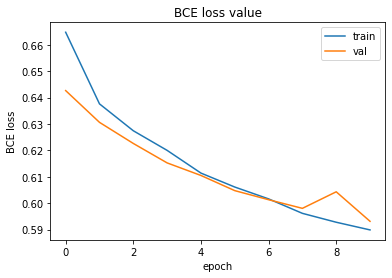

In [185]:
plt.plot(mix_np_losses)
plt.plot(mix_np_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

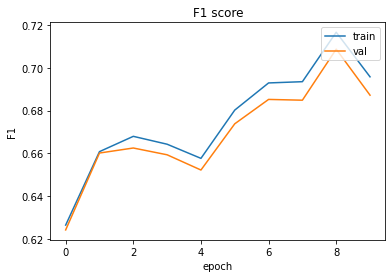

In [186]:
plt.plot(mix_np_f1s)
plt.plot(mix_np_f1s_eval)
plt.title('F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Попробуем увеличить акцент на триграммы символов, поскольку у нас больше нет пунктуации и, соответственно смайликов типа ":)" и т.д. Возможно, модель найдет какие-то триграммы, которые окажутся полезными для классификации. Вместо 80 выходных нейронов делаем 150:

In [199]:
class MixedCNN_improved(nn.Module):
    
    def __init__(self,
                 token_vocab_size,
                 symbol_vocab_size,
                 char_embedding_dim):
        super().__init__()
        
        self.token_embedding = nn.Embedding.from_pretrained(torch.Tensor(fasttext_embeddings))
        self.token_hidden = nn.Linear(100, 100)
        
        self.char_embedding = nn.Embedding(symbol_vocab_size, char_embedding_dim)
        self.char_bigrams = nn.Conv1d(in_channels=char_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.char_trigrams = nn.Conv1d(in_channels=char_embedding_dim, out_channels=150, kernel_size=3, padding='same')
        
        self.char_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.hidden_out = nn.Linear(350, 1)
        self.out = nn.Sigmoid()
    
    def forward(self, tokens, chars):
        tokens_embedded = self.token_embedding(tokens)
        tokens_embedded = tokens_embedded.transpose(1,2).max(2)[0]
        token_hidden = self.token_hidden(tokens_embedded)
        
        char_embedded = self.char_embedding(chars)
        char_embedded = char_embedded.transpose(1,2)
        feature_map_bigrams = self.char_pooling(self.relu(self.char_bigrams(char_embedded)))
        feature_map_trigrams = self.char_pooling(self.relu(self.char_trigrams(char_embedded)))
        pooling_bigrams = feature_map_bigrams.max(2)[0]
        pooling_trigrams = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling_bigrams, pooling_trigrams), 1)
        
        concat_out = torch.cat((token_hidden, concat), 1)
        logits = self.hidden_out(concat_out)
        logits = self.out(logits)
        return logits

In [200]:
model = MixedCNN_improved(len(id2token), len(id2symbol), 10)
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [201]:
imp_mix_np_losses, imp_mix_np_losses_eval, imp_mix_np_f1s, imp_mix_np_f1s_eval = train_and_evaluate(model, train_iterator, val_iterator, optimizer, criterion, 10)


starting Epoch 0
Training...
Train loss: 0.6920910222189767
Train loss: 0.6768536797591618
Train loss: 0.6695681696846372
Train loss: 0.6635663666895457
Train loss: 0.6598856912340436

Evaluating on train...
Val loss: 0.6372926677976336, Val f1: 0.6585112810134888
Val loss: 0.6383646726608276, Val f1: 0.6570210456848145
Val loss: 0.6377396509760902, Val f1: 0.6576496362686157
Val loss: 0.6385188324110849, Val f1: 0.6558632254600525
Val loss: 0.6382994025094169, Val f1: 0.6556969881057739

Evaluating on test...
Val loss: 0.6377592417928908, Val f1: 0.6564961075782776
Val loss: 0.6380789147482978, Val f1: 0.6542075276374817
Val loss: 0.6365418213385122, Val f1: 0.6584086418151855
Val loss: 0.6373528175883822, Val f1: 0.656279981136322
Val loss: 0.6379497236675686, Val f1: 0.654357373714447

starting Epoch 1
Training...
Train loss: 0.6401648947170803
Train loss: 0.6364960508687155
Train loss: 0.6348265358379909
Train loss: 0.6333580587591444
Train loss: 0.6317204243796213

Evaluating on 

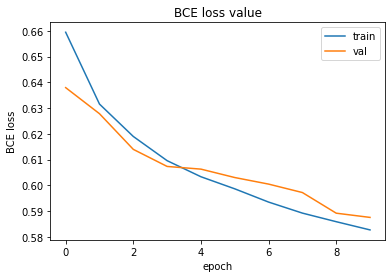

In [202]:
plt.plot(imp_mix_np_losses)
plt.plot(imp_mix_np_losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

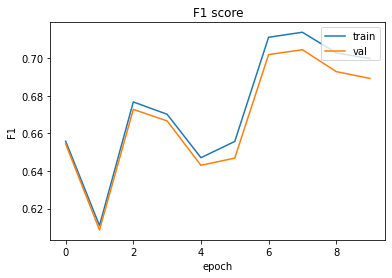

In [203]:
plt.plot(imp_mix_np_f1s)
plt.plot(imp_mix_np_f1s_eval)
plt.title('F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Мы видим, что благодаря этому F-мера слегка улучшилась, однако все еще не так высока. В любом случае, можно предположить, что больший акцент на триграммы символов при отсутствии пунктуации помогает.

In [ ]:
# made by nejenek